This notebook performs survival analysis on TCGA.BRCA data, using BRCA1 and BRCA2 mutations to separate patients

In [8]:
library(tidyverse)
library(car)
library(ggpubr)
library(gtsummary)
library(survival)
library(xfun)
library(survminer)
library(patchwork)
library(dbscan)



Warning message:
“package ‘dbscan’ was built under R version 4.3.3”

Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram




In [9]:
Patient_metadata <- read_tsv('../../../data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv')

#Load latent space
# Latent_Space_Basal <- read_csv('../../../results/tables/latent_space_BRCA_Basal.csv')
# Latent_Space_Her2 <- read_csv('../../../results/tables/latent_space_BRCA_Her2.csv')
# Latent_Space_LumA <- read_csv('../../../results/tables/latent_space_BRCA_LumA.csv')
# Latent_Space_LumB <- read_csv('../../../results/tables/latent_space_BRCA_LumB.csv')
Latent_Space <- read_csv('../../../results/tables/OG_latent_space.csv')
#Latent_Space <- Latent_Space_Her2

#Data Prep
#Rename variables
Patient_metadata <- Patient_metadata %>% rename(Age=`Diagnosis Age`)
Patient_metadata <- Patient_metadata %>% rename(patient_id=`Patient ID`,sample_id=`Sample ID`)
Patient_metadata <- Patient_metadata %>% rename(`histological_type` = `Tumor Type`)
Patient_metadata <- Patient_metadata %>% rename(ajcc_pathologic_tumor_stage=`Neoplasm Disease Stage American Joint Committee on Cancer Code`)

Patient_metadata <- Patient_metadata %>% mutate(Age10=Age/10)


Patient_metadata <- Patient_metadata %>% filter(!ajcc_pathologic_tumor_stage  %in% c('[Discrepancy]', '[Not Available]','Stage X','NA'))
Patient_metadata <- Patient_metadata %>% mutate(Stage = case_when(
  ajcc_pathologic_tumor_stage %in% c('STAGE I','STAGE IA', 'STAGE IB') ~ 'Stage I',
  ajcc_pathologic_tumor_stage %in% c('STAGE II',  'STAGE IIA',  'STAGE IIB' ) ~ 'STAGE II',
  ajcc_pathologic_tumor_stage %in% c('STAGE III', 'STAGE IIIA', 'STAGE IIIB', 'STAGE IIIC') ~ 'STAGE III',
  ajcc_pathologic_tumor_stage %in% c('STAGE IV') ~ 'STAGE IV',
))

#Modify latent space sample ids
Latent_Space <- Latent_Space %>% mutate(sample_id=str_sub(sample_id,1,15))

#Joint data
Joint_data <- Patient_metadata %>% inner_join(Latent_Space) 

#Ethnicity
Joint_data <- Joint_data %>% mutate(Ethnicity_white=ifelse(`Race Category`=='White','White','Non-White'))
Joint_data <- Joint_data %>% mutate(Ethnicity_white=ifelse(is.na(Ethnicity_white),'Non-White',Ethnicity_white))
Joint_data <- Joint_data %>% mutate(Ethnicity_white=as.factor(Ethnicity_white))
Joint_data$Ethnicity_white = relevel(Joint_data$Ethnicity_white,ref='White')

#Histological type
Joint_data <- Joint_data %>% filter(histological_type %in% c("Infiltrating Lobular Carcinoma","Infiltrating Ductal Carcinoma"))
Joint_data$histological_type <- as.factor(Joint_data$histological_type)

#Rename survival variables
Joint_data_Survival <- Joint_data %>% mutate(DSS.time=`Disease Free (Months)`)
#Joint_data_Survival <- Joint_data_Survival %>% filter(DSS.time<=50)
Joint_data_Survival <- Joint_data_Survival %>% mutate(DSS=`Disease Free Status`)
Joint_data_Survival <- Joint_data_Survival %>% mutate(DSS=ifelse(DSS=='0:DiseaseFree',0,1))
#Joint_data_Survival <- Joint_data_Survival %>% filter(histological_type=='Infiltrating Ductal Carcinoma')
Joint_data_Survival <- Joint_data_Survival %>% filter(Stage!='STAGE IV')


Rows: 1084 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (42): Study ID, Patient ID, Sample ID, Neoplasm Disease Stage American J...
dbl (19): Diagnosis Age, Aneuploidy Score, Buffa Hypoxia Score, Last Communi...
lgl  (2): Neoplasm Histologic Grade, Patient Weight

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 187 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): patient_id, sample_id
dbl (5): latent_0, latent_1, latent_2, latent_3, latent_4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(patient_id, sample_id)`


`geom_smooth()` using formula = 'y ~ x'


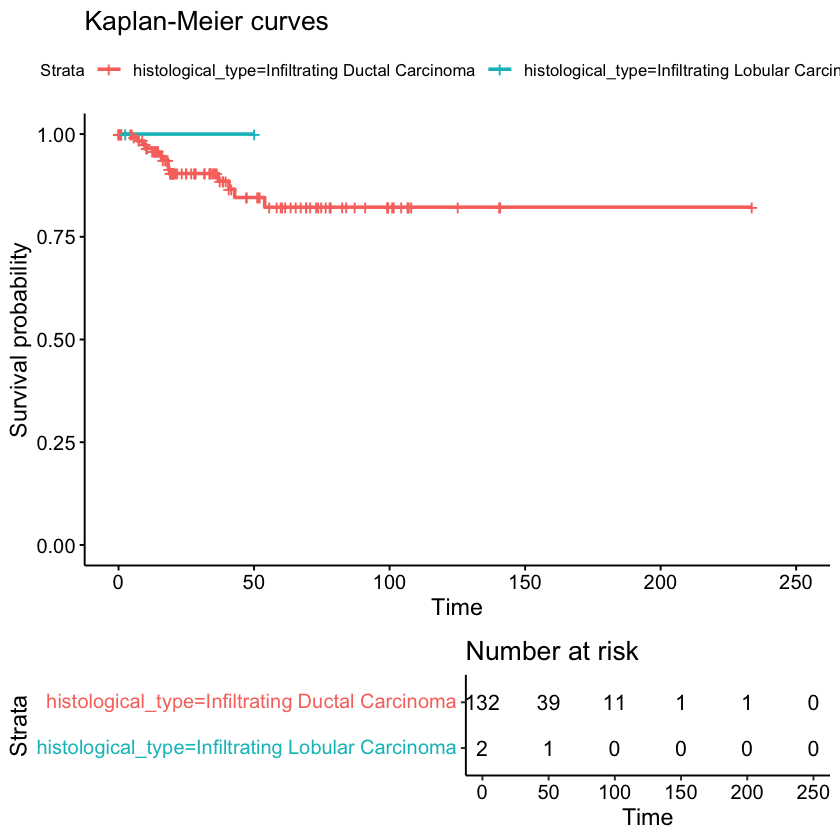

ERROR: Error in loadNamespace(x): there is no package called ‘umap’


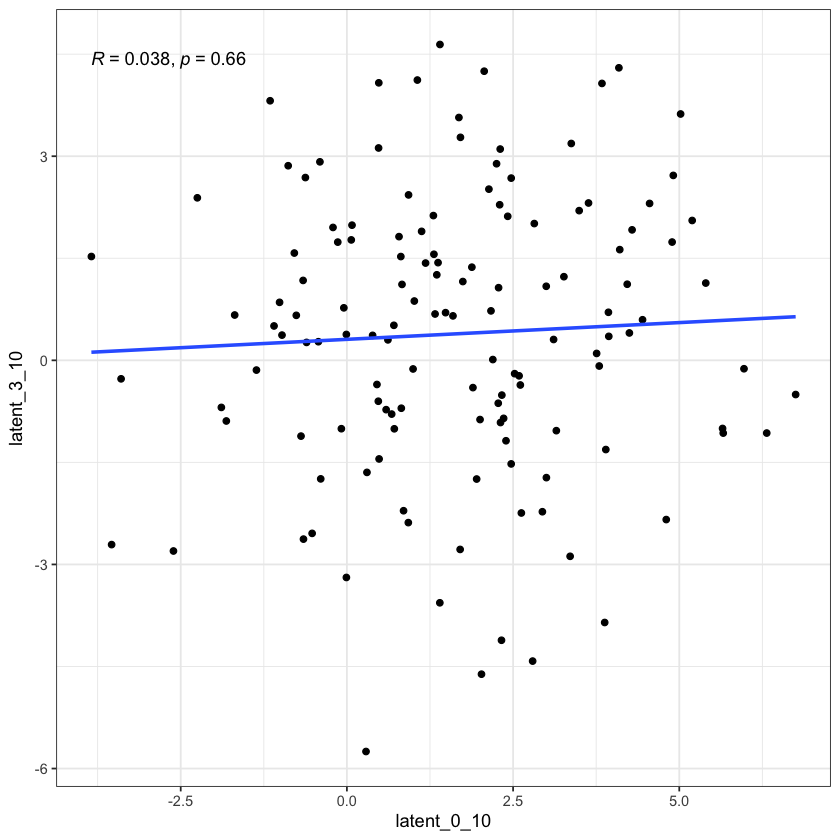

In [10]:
#Survival analysis
Joint_data_Survival <- Joint_data_Survival %>% filter(!is.na(DSS) & !is.na(DSS.time))
km.plot <- survfit(Surv(DSS.time, DSS) ~ histological_type, data = Joint_data_Survival)
ggsurvplot(km.plot,
           risk.table = TRUE,
           #legend.labs = c("Infiltrating Ductal Carcinoma", "Infiltrating Lobular Carcinoma"),
           title = "Kaplan-Meier curves")

Joint_data_Survival <- Joint_data_Survival %>% mutate(across(starts_with('latent'), ~ .x/10, .names = "{.col}_10"))

res.cox <- coxph(Surv(DSS.time, DSS) ~ Age + Ethnicity_white + Stage  + latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 +latent_4_10  , data = Joint_data_Survival %>% mutate(latent_4_10=latent_4/10))
res.cox <- coxph(Surv(DSS.time, DSS) ~ Age + Ethnicity_white + Stage   +latent_4_10 , data = Joint_data_Survival %>% mutate(latent_1_10=latent_1/10, latent_3_10=latent_3/10))
#tbl_regression(res.cox,exponentiate = TRUE)


ggplot(Joint_data_Survival, aes(x=latent_0_10, y=latent_3_10)) +  geom_point() + geom_smooth(method=lm, se=FALSE)+ stat_cor(method = "spearman") + theme_bw()


#dbSCAN
db <- dbscan(Joint_data_Survival %>% select(latent_0,latent_1,latent_2,latent_3,latent_4), eps = 15, minPts = 2)
Joint_data_Survival$cluster <- db$cluster

#UMAP
umap_results <- umap::umap(Joint_data_Survival %>% select(latent_0,latent_1,latent_2,latent_3,latent_4),n_components = 2, random_state = 15, min_dist =0.01,n_neighbors=5)
umap_plot_df <- data.frame(umap_results$layout)
final <- cbind(umap_plot_df, Joint_data_Survival$DSS.time) 


fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~Joint_data_Survival$DSS.time, type = 'scatter', mode = 'markers') %>%   layout( plot_bgcolor = "#e5ecf6", legend=list(title=list(text='Molecular type')), xaxis = list(  title = "0"),   yaxis = list(  title = "1"))
fig


In [28]:
# Add mutation data
Mutations <- read.csv('../../../../project-2/data//processed//TCGA.BRCA.mutations.qc1.txt', sep='\t')

# Extract non-synonymous mutations in BRCA1 and BRCA2
Mutations_N_BRCA1 <- unique(Mutations[which((Mutations$mutation_type == 'non-synonymous') & (Mutations$Hugo_Symbol == "BRCA1")),"patient_id"])
Mutations_N_BRCA2 <- unique(Mutations[which((Mutations$mutation_type == 'non-synonymous') & (Mutations$Hugo_Symbol == "BRCA2")),"patient_id"])

# add columns to Joint_Data_Survival
Joint_data_Survival$BRCA1_somatic_nonsyn <- ifelse(Joint_data_Survival$patient_id %in% Mutations_N_BRCA1, "yes", "no")
Joint_data_Survival$BRCA2_somatic_nonsyn <- ifelse(Joint_data_Survival$patient_id %in% Mutations_N_BRCA2, "yes", "no")
Joint_data_Survival$BRCA1_or_BRCA2_somatic_nonsyn <- ifelse((Joint_data_Survival$BRCA1_somatic_nonsyn == "yes") | (Joint_data_Survival$BRCA2_somatic_nonsyn == "yes"), "yes", "no")


In [42]:
coxph(
    Surv(DSS.time, DSS) ~ 
    Age + Ethnicity_white + Stage + latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 + latent_4_10, 
    data = Joint_data_Survival %>% mutate(latent_4_10=latent_4/10)
)


Call:
coxph(formula = Surv(DSS.time, DSS) ~ Age + Ethnicity_white + 
    Stage + latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 + 
    latent_4_10, data = Joint_data_Survival %>% mutate(latent_4_10 = latent_4/10))

                             coef exp(coef) se(coef)      z      p
Age                      -0.01955   0.98064  0.02312 -0.846 0.3977
Ethnicity_whiteNon-White  0.03052   1.03099  0.72934  0.042 0.9666
StageSTAGE II             0.09123   1.09552  1.11600  0.082 0.9348
StageSTAGE III            2.39145  10.92933  1.13617  2.105 0.0353
latent_0_10               0.20813   1.23138  0.19384  1.074 0.2829
latent_1_10              -0.79715   0.45061  0.56962 -1.399 0.1617
latent_2_10              -0.86557   0.42081  0.77526 -1.116 0.2642
latent_3_10               0.50596   1.65858  0.46793  1.081 0.2796
latent_4_10              -0.62630   0.53456  0.68045 -0.920 0.3574

Likelihood ratio test=16.44  on 9 df, p=0.05818
n= 134, number of events= 14 

In [43]:
coxph(
    Surv(DSS.time, DSS) ~ 
    Age + Ethnicity_white + Stage + latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 + latent_4_10 + BRCA1_or_BRCA2_somatic_nonsyn, 
    data = Joint_data_Survival %>% mutate(latent_4_10=latent_4/10)
)

Call:
coxph(formula = Surv(DSS.time, DSS) ~ Age + Ethnicity_white + 
    Stage + latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 + 
    latent_4_10 + BRCA1_or_BRCA2_somatic_nonsyn, data = Joint_data_Survival %>% 
    mutate(latent_4_10 = latent_4/10))

                                     coef exp(coef) se(coef)      z      p
Age                              -0.02169   0.97854  0.02374 -0.914 0.3608
Ethnicity_whiteNon-White          0.12055   1.12812  0.74591  0.162 0.8716
StageSTAGE II                     0.02280   1.02306  1.12612  0.020 0.9838
StageSTAGE III                    2.38368  10.84471  1.13771  2.095 0.0362
latent_0_10                       0.18991   1.20914  0.19037  0.998 0.3185
latent_1_10                      -0.79056   0.45359  0.55460 -1.425 0.1540
latent_2_10                      -0.85338   0.42597  0.76156 -1.121 0.2625
latent_3_10                       0.50148   1.65117  0.45275  1.108 0.2680
latent_4_10                      -0.61092   0.54285  0.67131 -0.91

In [33]:
coxph(
    Surv(DSS.time, DSS) ~ 
    Age + Ethnicity_white + Stage + BRCA1_or_BRCA2_somatic_nonsyn, 
    data = Joint_data_Survival %>% mutate(latent_4_10=latent_4/10)
)

Call:
coxph(formula = Surv(DSS.time, DSS) ~ Age + Ethnicity_white + 
    Stage + BRCA1_or_BRCA2_somatic_nonsyn, data = Joint_data_Survival %>% 
    mutate(latent_4_10 = latent_4/10))

                                     coef exp(coef) se(coef)      z      p
Age                              -0.01738   0.98277  0.02286 -0.761 0.4469
Ethnicity_whiteNon-White          0.13481   1.14432  0.60073  0.224 0.8224
StageSTAGE II                     0.39879   1.49001  1.07224  0.372 0.7100
StageSTAGE III                    2.47035  11.82660  1.08743  2.272 0.0231
BRCA1_or_BRCA2_somatic_nonsynyes  0.75188   2.12099  1.07754  0.698 0.4853

Likelihood ratio test=12.25  on 5 df, p=0.0315
n= 134, number of events= 14 

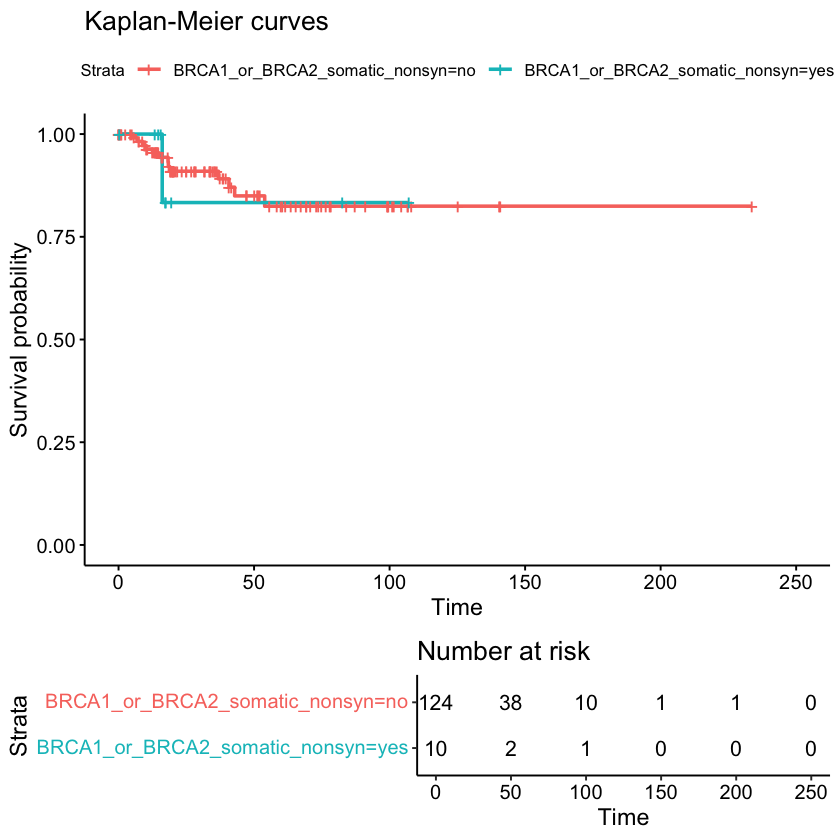

In [36]:
km.plot <- survfit(Surv(DSS.time, DSS) ~ BRCA1_or_BRCA2_somatic_nonsyn, data = Joint_data_Survival)
ggsurvplot(km.plot,
           risk.table = TRUE,
           #legend.labs = c("Infiltrating Ductal Carcinoma", "Infiltrating Lobular Carcinoma"),
           title = "Kaplan-Meier curves")

In [39]:
Joint_data_Survival$BRCA1_or_BRCA2_somatic_nonsyn <- as.factor(Joint_data_Survival$BRCA1_or_BRCA2_somatic_nonsyn)
model <- glm(BRCA1_or_BRCA2_somatic_nonsyn ~ latent_0_10 + latent_1_10 + latent_2_10 + latent_3_10 + 
    latent_4_10, data=Joint_data_Survival, family='binomial')
summary(model)


Call:
glm(formula = BRCA1_or_BRCA2_somatic_nonsyn ~ latent_0_10 + latent_1_10 + 
    latent_2_10 + latent_3_10 + latent_4_10, family = "binomial", 
    data = Joint_data_Survival)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.2526     0.6873  -4.733 2.21e-06 ***
latent_0_10  -0.1083     0.2170  -0.499   0.6178    
latent_1_10   1.1333     0.6481   1.749   0.0803 .  
latent_2_10   1.4384     0.7318   1.966   0.0493 *  
latent_3_10  -0.9639     0.4385  -2.198   0.0280 *  
latent_4_10   1.0368     0.6798   1.525   0.1272    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 71.140  on 133  degrees of freedom
Residual deviance: 63.357  on 128  degrees of freedom
AIC: 75.357

Number of Fisher Scoring iterations: 6


In [47]:
Mutations_N_BRCA1

[1] "TCGA-A1-A0SH" "TCGA-A1-A0SI" "TCGA-A2-A25B" "TCGA-A7-A26H" "TCGA-A7-A6VW"
 [6] "TCGA-AN-A0XU" "TCGA-AO-A1KR" "TCGA-AR-A0U4" "TCGA-B6-A0X1" "TCGA-C8-A12T"
[11] "TCGA-D8-A27M" "TCGA-E2-A1BD" "TCGA-E2-A1L9" "TCGA-EW-A2FR" "TCGA-LL-A5YP"
[16] "TCGA-LL-A8F5" "TCGA-S3-AA15"

In [48]:
Mutations_N_BRCA2

[1] "TCGA-A2-A0SU" "TCGA-A2-A0T0" "TCGA-AN-A0XW" "TCGA-AO-A124" "TCGA-AR-A1AI"
 [6] "TCGA-C8-A12T" "TCGA-C8-A278" "TCGA-D8-A1JP" "TCGA-D8-A1XL" "TCGA-E2-A14W"
[11] "TCGA-E9-A1R2" "TCGA-E9-A3HO" "TCGA-E9-A54Y" "TCGA-EW-A1PE" "TCGA-LD-A74U"
[16] "TCGA-LL-A73Y" "TCGA-S3-AA17"